In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# ml-latest-small dataset from https://grouplens.org/datasets/movielens/latest/
csv1 = os.path.join('movie_data', 'ml-latest-small', 'movies.csv')
csv2 = os.path.join('movie_data', 'ml-latest-small', 'ratings.csv')

In [3]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
action_df = movies_df[movies_df['genres'].str.contains('Action')]

In [7]:
ratings_df[ratings_df['movieId'].isin(action_df['movieId'])]\
    .loc[:, ['userId','rating']].groupby(['userId'])['rating'].mean()

userId
1      4.322222
2      3.954545
3      3.571429
4      3.320000
5      3.111111
         ...   
606    3.178808
607    3.722222
608    3.330325
609    3.090909
610    3.600580
Name: rating, Length: 608, dtype: float64

In [8]:
def get_genre_ratings(genres):
    genre_ratings = pd.DataFrame()
    column_names = []
    for genre in genres:        
        genre_movies = movies_df[movies_df['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings_df[ratings_df['movieId'].isin(genre_movies['movieId'])]\
            .loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        column = f'avg_{genre.lower()}_rating'
        column_names.append(column)
    genre_ratings.columns = column_names
    return genre_ratings

In [9]:
genre_ratings_df = get_genre_ratings(['Drama', 'Romance'])
genre_ratings_df.head()

,avg_drama_rating,avg_romance_rating
1,4.53,4.31
2,3.88,4.50
3,0.75,0.50
4,3.48,3.38
5,3.80,3.09


In [10]:
# biasing our dataset to attempt to remove userIds that like BOTH genres equally
bias_df = genre_ratings_df[((genre_ratings_df['avg_romance_rating'] < 3.5) & (genre_ratings_df['avg_drama_rating'] > 2.5)) \
                           | ((genre_ratings_df['avg_drama_rating'] < 3.5) & (genre_ratings_df['avg_romance_rating'] > 2.5))]

In [11]:
bias_df = pd.concat([bias_df, genre_ratings_df])
bias_df = pd.DataFrame(bias_df.to_records())
print(len(bias_df))
bias_df.head()

238


,index,avg_drama_rating,avg_romance_rating
0,4,3.48,3.38
1,5,3.80,3.09
2,7,3.13,2.65
3,9,3.43,3.17
4,10,3.15,3.33


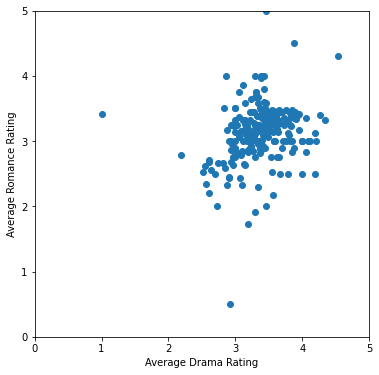

In [121]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

plt.xlim(0,5)
plt.ylim(0,5)
ax.set_xlabel('Average Drama Rating')
ax.set_ylabel('Average Romance Rating')
ax.scatter(bias_df['avg_drama_rating'], bias_df['avg_romance_rating'])
fig.savefig('images/ml/drama-vs-romance-1.png')

In [122]:
# convert values to list for processing
X = bias_df[['avg_drama_rating','avg_romance_rating']].values

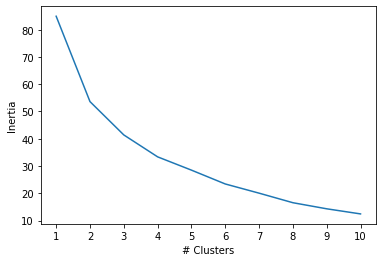

In [123]:
# eblow plot to determine clustering
inertia = []
k = list(range(1,11))

# for-loop for elbow plot
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    inertia.append(km.inertia_)
elbow = {"k": k, "inertia": inertia}
elbow_df = pd.DataFrame(elbow)

# plot elbow data
plt.plot(elbow_df['k'], elbow_df['inertia'])
plt.xticks(k)
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.show()
fig.savefig('images/ml/drama-vs-romance-elbow.png')

In [124]:
def k_means(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)

    predict = kmeans.fit_predict(X)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg drama rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([bias_df.reset_index(), pd.DataFrame({'group':predict})], axis=1)
    plt.scatter(clustered['avg_drama_rating'], clustered['avg_romance_rating'], c=clustered['group'])
    fig.savefig(f'images/ml/drama-vs-romance-kmeans-{n_clusters}.png')

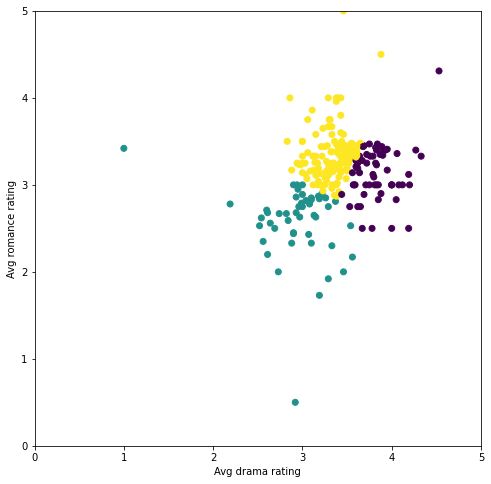

In [125]:
# K-Means with 3 clusters
k_means(3)

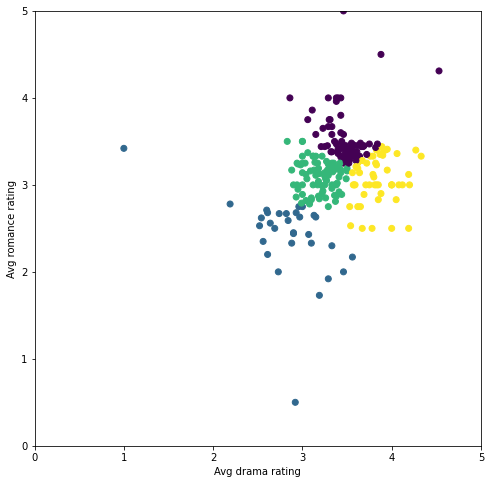

In [126]:
k_means(4)

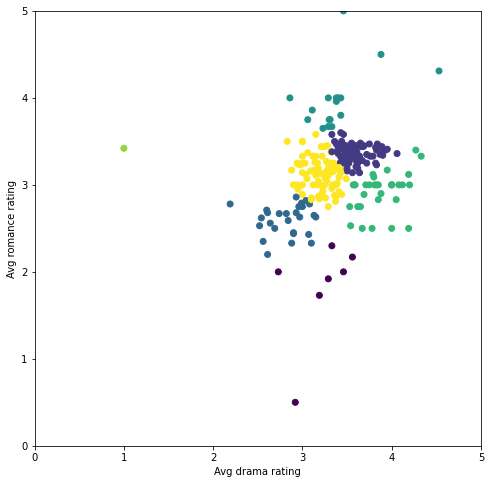

In [127]:
k_means(7)

In [128]:
top_genre_ratings = get_genre_ratings(['Film-Noir', 'War', 'Documentary', 'Crime', 'Drama', 'Mystery'])
columns = top_genre_ratings.columns

In [129]:
# import numpy as np
# for column in columns:
#     top_genre_ratings[column] = np.where(top_genre_ratings[column] >= 3.5, 1, 0)

In [130]:
top_genre_ratings.head()

,avg_film-noir_rating,avg_war_rating,avg_documentary_rating,avg_crime_rating,avg_drama_rating,avg_mystery_rating
1,5.0,4.50,NaN,4.36,4.53,4.17
2,NaN,4.50,4.33,3.80,3.88,4.00
3,NaN,0.50,NaN,0.50,0.75,5.00
4,4.0,3.57,4.00,3.81,3.48,3.48
5,NaN,3.33,NaN,3.83,3.80,4.00


In [131]:
top_genre_ratings = top_genre_ratings.dropna()

In [132]:
print(len(top_genre_ratings))

147


In [133]:
labels = top_genre_ratings['avg_drama_rating']
tgr_df = top_genre_ratings.drop('avg_drama_rating', axis=1)

In [134]:
print(len(labels))

147


In [135]:
tgr_df

,avg_film-noir_rating,avg_war_rating,avg_documentary_rating,avg_crime_rating,avg_mystery_rating
4,4.00,3.57,4.00,3.81,3.48
16,4.00,3.68,4.00,3.75,3.77
17,3.75,4.44,3.50,4.25,4.05
18,3.88,3.94,3.94,3.93,4.03
20,1.50,3.50,3.75,3.24,3.22
...,...,...,...,...,...
602,3.50,4.00,3.00,3.71,3.45
603,4.26,3.52,3.86,3.74,3.53
606,3.81,3.79,3.80,3.65,3.79
608,3.75,3.58,3.00,3.61,3.55


In [136]:
# Standardize your dataset so that columns that contain larger values do not influence the outcome more than columns with smaller values.
from sklearn.preprocessing import StandardScaler

# standardize our data using scaler
scaler = StandardScaler()
top_genres_scaled = scaler.fit_transform(tgr_df)

In [137]:
from sklearn.decomposition import PCA

# Apply Dimensionality Reduction
# 0.90 to preserve ~90% of explained variance
pca = PCA(n_components=0.90)
top_genre_pca = pca.fit_transform(top_genres_scaled)

# PCA converted to dataframe
top_genre_pca_df = pd.DataFrame(top_genre_pca)

# print sum of explained variance ratio
pca.explained_variance_ratio_.sum()

0.9125672340663407

In [141]:
from sklearn.manifold import TSNE

#t-SNE model

tsne = TSNE(learning_rate=35)
tsne_features = tsne.fit_transform(top_genre_pca_df)

In [142]:
tsne_features.shape

(147, 2)

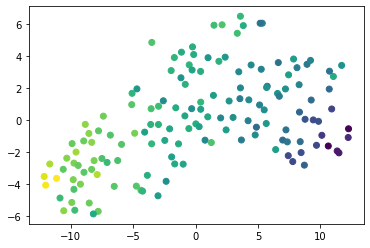

In [145]:
plt.scatter(tsne_features[:,0],tsne_features[:,1], c=labels)
plt.savefig('images/ml/drama-vs-romance-tsne.png')
plt.show()